In [1]:
from transformers import AutoImageProcessor, Dinov2Model
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import re
import torchvision
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import copy
from torchvision import datasets, models, transforms
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import time
from copy import deepcopy
from os import walk
import os
import copy
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from datasets import load_dataset,DatasetDict, Dataset
from torch.utils.data import Dataset, DataLoader
import cv2
import shutil
import random

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cpu')

In [4]:
batch_size = 64
num_epochs = 30
random_state = 10
cls = 7

In [5]:
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [6]:
# dinov2_vits14.load_state_dict(torch.load('dino_paper.pt'))

In [7]:
BASE_PATH = '../sample_paper/'

SEED = 1023
only_labels = ['BDT', 'FLT', 'GRT', 'MUD', 'PAC', 'RUD', 'WAC']
ch = 0
ch_group = [0]

def get_files(BASE_PATH):
    f = []
    for (dirpath, dirnames, filenames) in walk(BASE_PATH):
        f.extend(filenames)
        break
    return f

def creating_dataframe2(f, only_labels, base_path):
    ## assembling dataframe of file
    df_dict = {
        'path':[],
        'prof':[],
        'label':[],
        'channel':[],
        'tile':[]
    }

    prof_art_id=3
    lb_idx = 4
    ch_idx = 5
    tl_idx = 7
    lb_el=2    
        
    for file in f:
        split = re.split(r'(\d+)', file)
        
        prof_art = split[prof_art_id]
        label = split[lb_idx].split('.')[lb_el]
        channel = int(split[ch_idx])
        tile = int(split[tl_idx])
        
        if label in only_labels and not 'espessa' in file:
            
            tile = int(split[tl_idx])
            
            df_dict['path']+=[base_path+file]
            df_dict['prof']+=[prof_art] 
            df_dict['label']+=[label]
            df_dict['channel']+=[channel]
            df_dict['tile']+=[tile]
        
    df = pd.DataFrame(df_dict)
    return df

def split_A_B(df_raw, train_size=0.7):
 
    train, val, y_train, y_val = train_test_split(df_raw, df_raw.label.values, train_size=train_size, random_state=10)
    return train, val

def merge_with_channel(df_raw, df_split):
    new_df = copy.deepcopy(df_split)
    for idx, item in df_split.iterrows():
        
        cls = item[2]
        prof = item[1]
        tile = item[4]

        
        subdf = df_raw[(df_raw['label']==cls) & (df_raw['prof']==prof) & (df_raw['channel'].isin(ch_group))].iloc[:]
        new_df = pd.concat([new_df, subdf])
        
    return new_df
    

df = creating_dataframe2(get_files(BASE_PATH), only_labels, BASE_PATH)

df_raw = df[(df['channel']==ch) & (df['tile']==0)]

A, B = split_A_B(df_raw, 0.8)
print(len(A), len(B))
A, C = split_A_B(A, train_size=0.75)

train = A.drop_duplicates()
val = C.drop_duplicates()
test = B.drop_duplicates()

78237 19560


In [8]:
pd.merge(train, val, how='inner', on=['label','prof'])

,path_x,prof,label,channel_x,tile_x,path_y,channel_y,tile_y


In [9]:
pd.merge(train, test, how='inner', on=['label','prof'])

,path_x,prof,label,channel_x,tile_x,path_y,channel_y,tile_y


In [10]:
pd.merge(test, val, how='inner', on=['label','prof'])

,path_x,prof,label,channel_x,tile_x,path_y,channel_y,tile_y


<Axes: xlabel='label'>

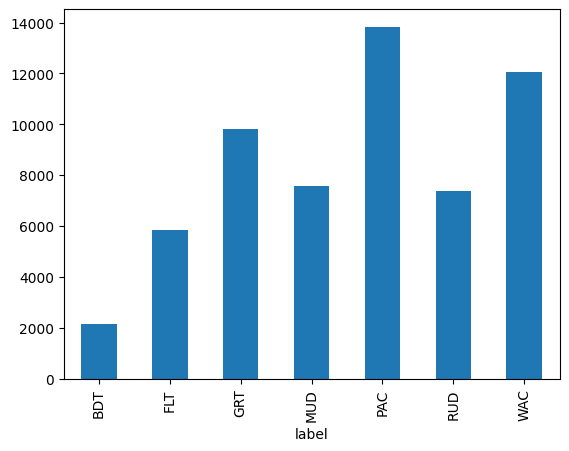

In [11]:
train.groupby(by='label')['label'].count().plot.bar()

In [ ]:
# import shutil

# root = '../data_experiment_splitted_paper/'

# for cl in only_labels:
#     dst = f"{root}train/{cl}/"
#     paths = train[(train['label']==cl) & (train['channel']==0)].path.values
#     if not os.path.isdir(dst):
#         print('criou')
#         os.makedirs(dst)
#     for path in paths:
#         shutil.copy(path, dst)

# for cl in only_labels:
#     dst = f"{root}val/{cl}/"
#     paths = val[(val['label']==cl) & (val['channel']==0)].path.values
#     if not os.path.isdir(dst):
#         print('criou')
#         os.makedirs(dst)
#     for path in paths:
#         shutil.copy(path, dst)

# for cl in only_labels:
#     dst = f"{root}test/{cl}/"
#     paths = test[(test['label']==cl) & (test['channel']==0)].path.values
#     if not os.path.isdir(dst):
#         print('criou')
#         os.makedirs(dst)
#     for path in paths:
#         shutil.copy(path, dst)

In [ ]:
data_dir = '../data_experiment_splitted_paper/'
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        # transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),#256
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256), #256 
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle = x, num_workers=4)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

class_names = image_datasets["train"].classes

print(class_names, dataset_sizes)

In [ ]:
idx_to_class = {i:j for i, j in enumerate(class_names)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

count_by_class = [class_to_idx[i] for i in train.label.values]
cls_weight = compute_class_weight('balanced',classes=np.unique(count_by_class),y=count_by_class)

In [ ]:
class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self,dinov2_vits14):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.transformer = deepcopy(dinov2_vits14)
        self.classifier = nn.Sequential(nn.Linear(384, 256), nn.ReLU(), nn.Linear(256, cls))

    def forward(self, x):
        x = self.transformer(x)
        x = self.transformer.norm(x)
        x = self.classifier(x)
        return x

model_ft = DinoVisionTransformerClassifier(dinov2_vits14)

In [ ]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):

        ce_loss = F.cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [ ]:
model_ft = model_ft.to(device)

weights = torch.FloatTensor(cls_weight).to(device)
#
criterion = FocalLoss(weight=weights)

# criterion = nn.CrossEntropyLoss(weight=weights)
    
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-6)

In [ ]:
def test_evaluation(model_ft, dataloaders, evaluation_name, is_logits=False):
    y_pred = []
    y_true = []
    model_ft.eval()
    i = 0
    with torch.set_grad_enabled(False):
        for X, y in dataloaders[evaluation_name]:
            X = X.to(device)
            pred = model_ft(X)
            if is_logits:
                y_pred+= pred.cpu().numpy().tolist() ## pra pegar a distribuição e não o max               
            else:
                _, preds = torch.max(pred, 1)
                y_pred+= preds.cpu().numpy().tolist()
                
            y_true+= y.numpy().tolist()
            i+=1        
    return y_true, y_pred

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    train_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10
    
    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
       
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                                     
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:# and epoch_loss < best_loss:
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                train_acc_history.append(epoch_acc)

        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history

In [ ]:
model_ft, hist_train, hist_val = train_model(model_ft, dataloaders, criterion, optimizer_ft,  num_epochs=num_epochs, is_inception=False)

In [ ]:
y_true, y_pred = test_evaluation(model_ft, dataloaders, 'test')

In [ ]:
cm = confusion_matrix(y_true, y_pred, labels=list(class_to_idx.values()))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cmn , display_labels=list(idx_to_class.values()))
disp.plot()

In [ ]:
print(classification_report(y_true, y_pred, target_names=list(idx_to_class.values())))

In [ ]:
# torch.save(model_ft.transformer.state_dict(), 'dino_paper.pt')

In [ ]:
model_ft.classifier

In [ ]:
model_ft

In [ ]:
train Loss: 0.0494 Acc: 0.9355
  3%|█▎                                       | 1/30 [06:05<2:56:31, 365.22s/it]
val Loss: 0.0045 Acc: 0.9688



Epoch 0/29
----------
train Loss: 0.2199 Acc: 0.7598
  3%|█▎                                       | 1/30 [05:59<2:53:57, 359.90s/it]
val Loss: 0.0520 Acc: 0.8791
Epoch 1/29